# <center>Computing the count rate of observing <a href="https://en.wikipedia.org/wiki/HAT-P-11">HAT-P-11</a> with the APO 3.5m telescope using <tt>synphot</tt></center>

In [42]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import astropy.units as u
from astropy.io import fits
from astropy.utils.data import download_file

import synphot.units as units
from synphot.models import Empirical1D
from synphot.spectrum import SourceSpectrum, SpectralElement
from synphot.observation import Observation

### Compute the photon flux (of HAT-P-11)

First we are going to download a model spectrum for HAT-P-11 from <a href="http://phoenix.astro.physik.uni-goettingen.de/">PHOENIX</a>:

In [43]:
T_eff = 4800 # approx temperature of hatp11[K], Bakos et al. 2010

url = ('ftp://phoenix.astro.physik.uni-goettingen.de/v2.0/HiResFITS/'
       'PHOENIX-ACES-AGSS-COND-2011/Z-0.0/lte{T_eff:05d}-{log_g:1.2f}-0.0.PHOENIX-'
       'ACES-AGSS-COND-2011-HiRes.fits').format(T_eff=T_eff, log_g=4.5)
# Unit from PHOENIX model file:
flux = fits.getdata(url) * (u.erg / u.s / u.cm ** 2 / u.cm)

wavelength_url = ('ftp://phoenix.astro.physik.uni-goettingen.de/v2.0/HiResFITS/'
                  'WAVE_PHOENIX-ACES-AGSS-COND-2011.fits')
wavelengths = fits.getdata(wavelength_url) * u.Angstrom

Then construct a `synphot` <a href="https://synphot.readthedocs.io/en/latest/synphot/spectrum.html#arrays">source spectrum object</a> from the above arrays:

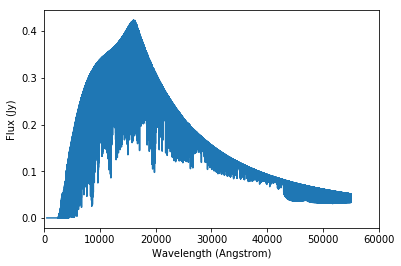

In [44]:
photlam_hatp11 = SourceSpectrum(Empirical1D,
                                points=wavelengths, lookup_table=flux)

# Compute the flux at Earth from the luminosity 
stellar_radius = 0.683 * u.R_sun  # radius in solar units, Deming et al. 2011
distance = 123 * u.lyr # distance to HATP11 in light years from Gaia parallax
photlam_hatp11 = photlam_hatp11 * float(stellar_radius / distance) ** 2 / np.pi

photlam_hatp11.plot(flux_unit='Jy', left=0, right=60000)

(for other methods of constructing source spectra with `synphot`, see the first bulleted list <a href="https://synphot.readthedocs.io/en/latest/synphot/spectrum.html#arrays">here</a>) 

### Simulate the observation with a specific instrument

<p>Let's observe HAT-P-11 with the <a href="https://www.apo.nmsu.edu/arc35m/Instruments/ARCTIC/">ARCTIC instrument</a> on APO's 3.5m telescope.

In [45]:
aperture_radius = 3.5 / 2 * u.m  # radius of 3.5m ARC telescope at APO
aperture_area = np.pi * aperture_radius ** 2
gain = 1.9  # the gain of this detector in e-/ADU

For the bandpass we will use the SDSS r- and z- filters whose transmission functions we query from <a href="http://svo2.cab.inta-csic.es/theory/fps/index.php?mode=voservice">SVO</a>. 
<p>To construct a bandpass from a file with <tt>synphot</tt>, use <a href="https://synphot.readthedocs.io/en/latest/api/synphot.spectrum.SpectralElement.html#synphot.spectrum">SpectralElement</a>:</p>

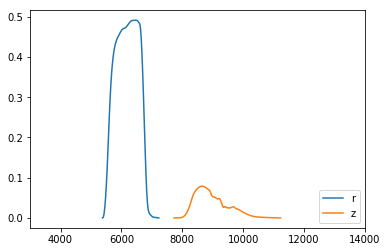

In [46]:
svo_link = 'http://svo2.cab.inta-csic.es/theory/fps/fps.php?ID=SLOAN/SDSS.'
sdss = ['r', 'z']  # only want r- and z-bands for now

bandpasses = {}
for band in sdss:
    local_path = download_file(svo_link + band)
    bp = SpectralElement.from_file(local_path)
    bandpasses[band] = bp
    
    plt.plot(bp.waveset, bp(bp.waveset), label=band)
plt.legend(loc='lower right')
plt.xlim(3000, 14000)
plt.show()
    

Then we model the attenuation by the atmosphere using the Cerro Paranal model transmittance curves for an airmass of 1.5:

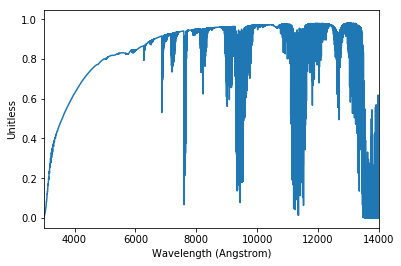

In [48]:
atmosphere = SpectralElement.from_file('CerroParanal-atmosx1.5.txt', wave_unit="nm")
atmosphere.plot(left=3000, right=14000)

We also model the affect of the CCD's quantum efficiency on the spectrum. For this we use the values in the table found in section 3.5 on <a href="https://www.apo.nmsu.edu/arc35m/Instruments/ARCTIC/#3p5">this page</a>.

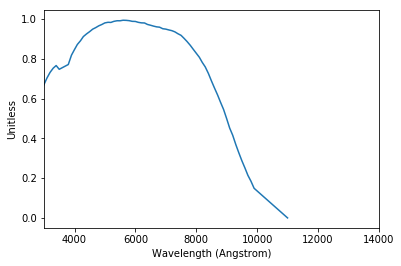

In [49]:
quantum_efficiency = SpectralElement.from_file('ccd_QE.csv', wave_unit="nm")
quantum_efficiency._model.lookup_table /= 100  # convert percentages to decimals

quantum_efficiency.plot(left=3000, right=14000)

Once we have all of the effects on the source spectrum set, we can combine them together by simply multiplying the SpectralElement objects:

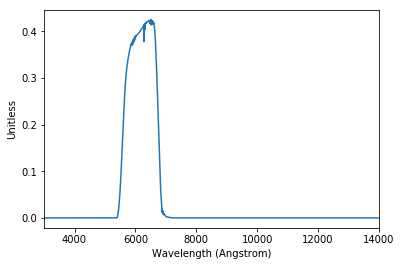

In [50]:
bp_atmos_qe = {} # setting up a dictionary for the different SDSS bands
for band in sdss:
    bp_atmos_qe[band] = bandpasses[band] * atmosphere * quantum_efficiency
    
bp_atmos_qe['r'].plot(left=3000, right=14000)

Finally, we convolve the source spectrum with all of these effects using <tt>synphot</tt>'s <a href="https://synphot.readthedocs.io/en/latest/synphot/observation.html">Observation</a>:

In [69]:
band = 'r'  # only want to know about the r-band

observation = Observation(photlam_hatp11, 
                      bp_atmos_qe[band],
                      binset=bp_atmos_qe[band].waveset,
                      force='taper')

To get the expected count rate for a specific collecting area, use the <a href="https://synphot.readthedocs.io/en/latest/api/synphot.observation.Observation.html#synphot.observation.Observation.countrate">countrate()</a> method on the observation object: 

In [70]:
waverange = (3000, 11300) # according to the ARCTIC webpage, the z band is cut off around 11k AA

countrate = observation.countrate(area=aperture_area, waverange=waverange) / gain

How many counts can we expect in a 10s exposure?

In [71]:
counts_hatp11 = countrate * 10 * u.s

print("HAT-P-11 counts in the r-band, 10 s exposure:")
print(int(counts_hatp11.value), "cts")

HAT-P-11 counts in the r-band, 10 s exposure:
12480841 cts


# <center>Same instrument and telescope, this time observing <a href="https://en.wikipedia.org/wiki/TRAPPIST-1">TRAPPIST-1</a></center>

In [72]:
T_eff = 2500 # approx temperature of trappist-1 [K], Delrez et al. 2018

url = ('ftp://phoenix.astro.physik.uni-goettingen.de/v2.0/HiResFITS/'
       'PHOENIX-ACES-AGSS-COND-2011/Z-0.0/lte{T_eff:05d}-{log_g:1.2f}-0.0.PHOENIX-'
       'ACES-AGSS-COND-2011-HiRes.fits').format(T_eff=T_eff, log_g=4.5)
# Unit from PHOENIX model file:
flux = fits.getdata(url) * (u.erg / u.s / u.cm ** 2 / u.cm)

wavelength_url = ('ftp://phoenix.astro.physik.uni-goettingen.de/v2.0/HiResFITS/'
                  'WAVE_PHOENIX-ACES-AGSS-COND-2011.fits')
wavelengths = fits.getdata(wavelength_url) * u.Angstrom

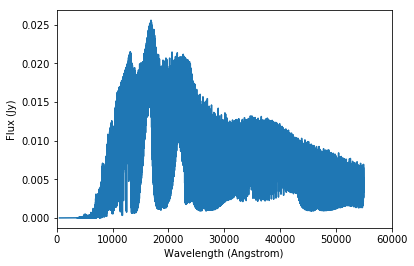

In [73]:
photlam_trappist1 = SourceSpectrum(Empirical1D,
                                points=wavelengths, lookup_table=flux)

# Compute the flux at Earth from the luminosity 
stellar_radius = 0.121 * u.R_sun  # radius of trappist-1 in solar units, Van Grootel et al. 2018
distance = 39.6 * u.lyr  # distance to trappist-1 in light years from Gaia parallax
photlam_trappist1 = photlam_trappist1 * float(stellar_radius / distance) ** 2 / np.pi

photlam_trappist1.plot(flux_unit='Jy', left=0, right=60000)

This time I just want to know about observations in the z-band:

In [78]:
band = 'z'
observation = Observation(photlam_trappist1, 
                      bp_atmos_qe[band],
                      binset=bp_atmos_qe[band].waveset,
                      force='taper')

countrate = observation.countrate(area=aperture_area, waverange=waverange) / gain
counts_trappist1 = countrate * 10 * u.s

print("TRAPPIST-1 counts in the z-band, 10 s exposure:")
print(int(counts_trappist1.value), "cts")

TRAPPIST-1 counts in the z-band, 10 s exposure:
13401 cts


### We know from observations using AGILE on APO's 3.5m telescope that the actual count values for these stars taken on {date} are:

In [75]:
hatp11_r_observed = 34000000
print('HAT-P-11 in r-band:', hatp11_r_observed / 1e6, 'million counts')

HAT-P-11 in r-band: 34.0 million counts


In [76]:
trappist1_z_observed = 203000
print('TRAPPIST-1 in z-band:', trappist1_z_observed / 1e3, 'thousand counts')

TRAPPIST-1 in z-band: 203.0 thousand counts


Comparing our expected values to the observed values on a 1-1 line:

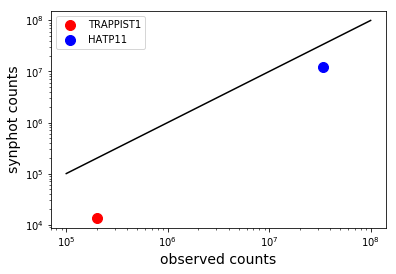

In [77]:
plt.scatter(trappist1_z_observed, counts_trappist1, color='r', s=100, label='TRAPPIST1')
plt.scatter(hatp11_r_observed, counts_hatp11, color='b', s=100, label="HATP11")

# one-to-one line
plt.plot(np.linspace(1e5, 1e8, 20), np.linspace(1e5, 1e8, 20), color='black')

plt.xscale('log')
plt.yscale('log')

plt.ylabel('synphot counts', size='14')
plt.xlabel('observed counts', size='14')

plt.legend()